In [ ]:
!pip install numpy nltk

# File i/o
import json
import nltk
nltk.download('punkt')

# Functionality
import re

# Google drive information
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Data/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive/
/content/drive/My Drive/Data


##Reading the Traning Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the training file
f = open('train.json')
data = json.load(f)

In [ ]:
# We can see some entries to see the format
data[:3]

[{'id': '65635',
  'text': 'THIS IS WHY YOU NEED\\n\\nA SHARPIE WITH YOU AT ALL TIMES',
  'labels': ['Black-and-white Fallacy/Dictatorship'],
  'link': 'https://www.facebook.com/photo/?fbid=4023552137722493&set=g.633131750534436'},
 {'id': '67927',
  'text': 'GOOD NEWS!\\n\\nNAZANIN ZAGHARI-RATCLIFFE AND ANOOSHEH ASHOORI HAVE BEEN RELEASED\\n\\nAfter years of being unjustly detained in Iran, they are making their way safely back to the UK.',
  'labels': ['Loaded Language', 'Glittering generalities (Virtue)'],
  'link': 'https://www.facebook.com/amnesty/photos/5311988665480629/'},
 {'id': '68031',
  'text': 'PAING PHYO MIN IS FREE!',
  'labels': [],
  'link': 'https://www.facebook.com/amnesty/photos/4274191309260375/'}]

##Tokenization

Here, we process the text by tokenizing end characters and converting all tokens to lowercase

In [ ]:
newList = []
# Tokenize 'text' and 'labels' fields
for item in data:

    # Tokenize 'labels'
    tokens_labels = [label.lower() for label in item['labels']]
    tokens_text = item['text'].lower()
    reg = re.compile("\\n")
    token = re.split("(\\\\n)+", tokens_text)
    new_text = ""
    for t in token:
      new_text = new_text + " " + t
    #if len(tokens_labels) == 0:
    #  tokens_labels = ['normal']
    newList.append({
        'id': item['id'],
        'text': new_text,
        'labels': tokens_labels,
        'link': item['link']
    })

# Write the updated list back to the JSON file
with open('train_tokenized.json', 'w') as f:
    json.dump(newList, f, indent=2)

Reading the tokenized json file

In [ ]:
f = open('train_tokenized.json')
data = json.load(f)
data[:3]

[{'id': '65635',
  'text': ' this is why you need \\n a sharpie with you at all times',
  'labels': ['black-and-white fallacy/dictatorship'],
  'link': 'https://www.facebook.com/photo/?fbid=4023552137722493&set=g.633131750534436'},
 {'id': '67927',
  'text': ' good news! \\n nazanin zaghari-ratcliffe and anoosheh ashoori have been released \\n after years of being unjustly detained in iran, they are making their way safely back to the uk.',
  'labels': ['loaded language', 'glittering generalities (virtue)'],
  'link': 'https://www.facebook.com/amnesty/photos/5311988665480629/'},
 {'id': '68031',
  'text': ' paing phyo min is free!',
  'labels': [],
  'link': 'https://www.facebook.com/amnesty/photos/4274191309260375/'}]

##Data Analysis
Value count of label column.

Text(0, 0.5, 'Normalized Value Counts')

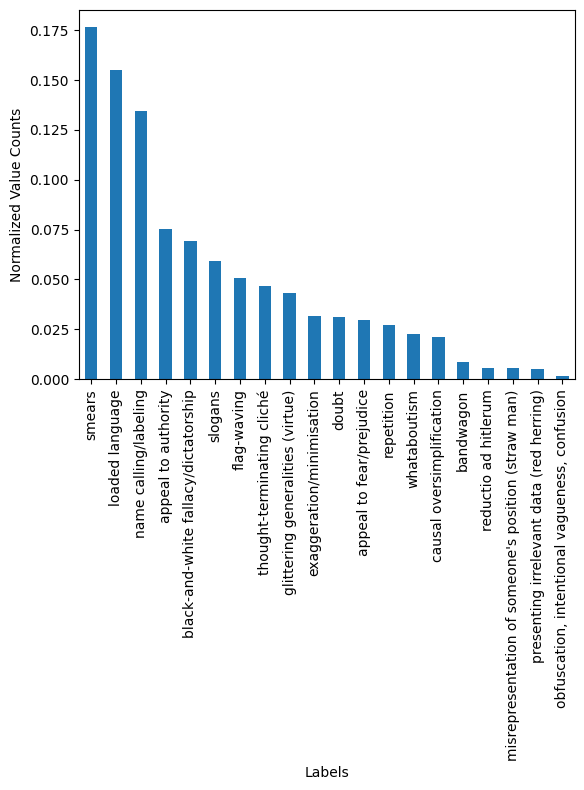

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df["labels"].explode().value_counts(normalize=True).plot.bar()
plt.xlabel("Labels")
plt.ylabel("Normalized Value Counts")

Checking labels containing empty list.

In [ ]:
empty_lists = df['labels'].apply(lambda x: len(x) == 0)

print(empty_lists)

0       False
1       False
2        True
3        True
4       False
        ...  
6995    False
6996    False
6997     True
6998     True
6999    False
Name: labels, Length: 7000, dtype: bool


In [ ]:
num_empty_lists = empty_lists.sum()
print(num_empty_lists)

1264


Dropping the labels with empty lists.
(Commented out because the accuracy dropped drastically after implementing.)

In [ ]:
#non_empty_lists = df['labels'].apply(lambda x: len(x) > 0)
#df = df[non_empty_lists].reset_index(drop=True)
#print("length", len(df.labels))
#df.to_json('train_tokenized.json', orient='records', lines=True)



In [ ]:
#with open('train_tokenized.json') as f:
#    data = [json.loads(line) for line in f]

In [ ]:
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

Dataset_inputs = []

for item in data:
    # Applying regular expression to remove non-alphabetic characters
    text = re.sub('[^a-zA-Z0-9]', ' ', item["text"])

    # Converting to lowercase
    text = text.lower()

    # Tokenization
    words = text.split()

   # Removing stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    #Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    #Joining the words back into a string
    processed_text = ' '.join(words)

    item["text"] = processed_text

    Dataset_inputs.append(item["text"])



Dataset_labels = []
for item in data:
  Dataset_labels.append(item["labels"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Spitting the data
Spitting the dataset into training and testing data.

In [ ]:
from sklearn.model_selection import train_test_split

texts_train, texts_val, labels_train, labels_val = train_test_split(Dataset_inputs, Dataset_labels, test_size=0.2, random_state=42)

Vectorizing the input features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() #removes the stop words only.
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)


Using MultiLabelBinarzer for multiple labels

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(labels_train)
y_val = mlb.transform(labels_val)

# https://scikit-learn.org/stable/modules/multiclass.html#:~:text=Multioutput%20regression%20predicts%20multiple%20numerical,than%20just%20running%20n_output%20estimators

## Logistic Regression
Logistic regression is our baseline model, wrapped in a Multioutput regressor to accomodate multiple output labels

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Fit the model
model = MultiOutputRegressor(LogisticRegression(multi_class='multinomial', max_iter=1000))
model.fit(X_train, y_train)

# Predict
y_val_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(y_val, y_val_pred, target_names=mlb.classes_)
print('Classification Report:')
print(classification_rep)

# https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html

Accuracy: 0.21785714285714286
Classification Report:
                                                     precision    recall  f1-score   support

                                appeal to authority       0.59      0.30      0.40       174
                           appeal to fear/prejudice       0.27      0.07      0.11        60
                                          bandwagon       0.25      0.07      0.11        15
               black-and-white fallacy/dictatorship       0.36      0.13      0.20       164
                          causal oversimplification       0.50      0.04      0.07        53
                                              doubt       0.50      0.09      0.16        87
                          exaggeration/minimisation       0.36      0.10      0.16        79
                                        flag-waving       0.55      0.30      0.38       115
                   glittering generalities (virtue)       0.37      0.14      0.20        81
                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LinearSVC
Here, we try LinearSVC to compare against Logistic Regression

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier


svm_model = MultiOutputClassifier(LinearSVC(max_iter=5000))

# Fit the model
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = svm_model.predict(X_val)


# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(y_val, y_val_pred, target_names=mlb.classes_)
print('Classification Report:')
print(classification_rep)

#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


Accuracy: 0.18928571428571428
Classification Report:
                                                     precision    recall  f1-score   support

                                appeal to authority       0.53      0.38      0.44       174
                           appeal to fear/prejudice       0.12      0.08      0.10        60
                                          bandwagon       0.33      0.33      0.33        15
               black-and-white fallacy/dictatorship       0.26      0.20      0.22       164
                          causal oversimplification       0.50      0.11      0.18        53
                                              doubt       0.21      0.08      0.12        87
                          exaggeration/minimisation       0.21      0.14      0.17        79
                                        flag-waving       0.45      0.37      0.40       115
                   glittering generalities (virtue)       0.23      0.22      0.22        81
                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## One Vs Rest (Alternative Implementation)
Please note that this One Vs Rest algorithm is an alternative implementation to the above. The MultiOutputClassifier and Regressor apply the same One Vs Rest approach to handling multiple outputs


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

# # # # linearSVC # # # #
# Fit the model
ovrSVC = OneVsRestClassifier(LinearSVC(max_iter = 3000)).fit(X_train, y_train)

# Predict the values
y_val_pred = ovrSVC.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(y_val, y_val_pred, target_names=mlb.classes_)
print('Classification Report:')
print(classification_rep)


# # # # LOGISTIC REGRESSION # # # #
# Fit the model
ovrLR = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', max_iter=3000)).fit(X_train, y_train)

# Predict the values
y_val_pred = ovrLR.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(y_val, y_val_pred, target_names=mlb.classes_)
print('Classification Report:')
print(classification_rep)

# https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

Accuracy: 0.19071428571428573
Classification Report:
                                                     precision    recall  f1-score   support

                                appeal to authority       0.54      0.45      0.49       174
                           appeal to fear/prejudice       0.20      0.15      0.17        60
                                          bandwagon       0.15      0.13      0.14        15
               black-and-white fallacy/dictatorship       0.32      0.25      0.28       164
                          causal oversimplification       0.32      0.11      0.17        53
                                              doubt       0.31      0.10      0.16        87
                          exaggeration/minimisation       0.27      0.16      0.20        79
                                        flag-waving       0.45      0.41      0.43       115
                   glittering generalities (virtue)       0.26      0.23      0.25        81
                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Accuracy: 0.21285714285714286
Classification Report:
                                                     precision    recall  f1-score   support

                                appeal to authority       0.57      0.38      0.46       174
                           appeal to fear/prejudice       0.15      0.05      0.07        60
                                          bandwagon       0.40      0.13      0.20        15
               black-and-white fallacy/dictatorship       0.45      0.21      0.28       164
                          causal oversimplification       0.40      0.08      0.13        53
                                              doubt       0.47      0.10      0.17        87
                          exaggeration/minimisation       0.37      0.13      0.19        79
                                        flag-waving       0.57      0.37      0.44       115
                   glittering generalities (virtue)       0.38      0.15      0.21        81
                

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.